# Neural & Behavioral Modeling - Week 13 (Exercises)
by 林子堯 (r08227112@ntu.edu.tw)

In [45]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import torch as t
from torch import nn
from torch import optim
from tabulate import tabulate

In [47]:
# Check GPU status:
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.7.0+cu101
Device  0 : Tesla T4
Current: Device  0


## 1. RNN on images (5 points)
Note that the RNN-based MNIST classifier in 2.1.1 of 13_examples.ipynb did not apply a softmax as the response function of its last layer.

Does adding a softmax make any difference in model prediciton performance? Why or why not?

Refs:

[1] https://pytorch.org/docs/stable/nn.html 

[2] https://pytorch.org/docs/stable/nn.functional.html 

[3] https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html

### 1.1 前置作業

下方 code 包含資料的載入和模型的設計。


In [37]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                 transforms.Normalize(mean=[0.5],std=[0.5])])

train_set = datasets.MNIST(root = "./data",
               transform = transform,
               train = True,
               download = True)

train_data = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)


test_set = datasets.MNIST(root = "./data",
              transform = transform,
              train = False)

test_data = t.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [38]:
# Supporting functions:

from datetime import datetime

def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


def train(device, net, train_data, valid_data, num_epochs, optimizer, criterion, print_result=True):
    tl, ta, vl, va = np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs)

    if t.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        #for im, label in train_data:
        for im, label in train_data:
            im=im.view(-1,im.shape[2],im.shape[3])
            im = im.to(device)  # (bs, h, w)
            label = label.to(device)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                with t.no_grad():
                    im=im.view(-1,im.shape[2],im.shape[3])
                    im = im.to(device)
                    label = label.to(device)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.data.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        if print_result:
          print(epoch_str + time_str)
        tl[epoch], ta[epoch], vl[epoch], va[epoch] = train_loss/len(train_data), train_acc / len(train_data), valid_loss / len(valid_data), valid_acc / len(valid_data)
        
    return tl, ta, vl, va

def simulation(times, device, srn_model, train_data, test_data, num_epochs, optimizer, criterion):
  train_loss, train_acc, valid_loss, valid_acc = np.zeros(times), np.zeros(times), np.zeros(times), np.zeros(times)
  
  for time in range(times):
    if srn_model == "RNN_addSoftmax":
      srn = RNN_addSoftmax()
    else:
      srn = RNN()
    optimizer = optim.Adam(srn.parameters())
    criterion = nn.CrossEntropyLoss()
    tl, ta, vl, va = train(device, srn, train_data, test_data, num_epochs, optimizer, criterion, print_result=False)
    train_loss[time], train_acc[time], valid_loss[time], valid_acc[time] = tl[-1], ta[-1], vl[-1], va[-1]
  
  print(tabulate([['N', times, times, times, times],
          ['Epochs', num_epochs, num_epochs, num_epochs, num_epochs,],
          ['Min', train_loss.min(), train_acc.min(), valid_loss.min(), valid_acc.min()], 
          ['Mean', train_loss.mean(), train_acc.mean(), valid_loss.mean(), valid_acc.mean()],
          ['Max', train_loss.max(), train_acc.max(), valid_loss.max(), valid_acc.max()],
          ['Standard deviaion', train_loss.std(), train_acc.std(), valid_loss.std(), valid_acc.std()]], 
          headers=['Statistic', 'Train loss', 'Train accuracy', 'Valid loss', 'Valid accuracy'], tablefmt='orgtbl'))

In [39]:
# Thoe model in 2.1.1 of 13_examples.ipynb:

class RNN(nn.Module):
  def __init__(self):
    super(RNN, self).__init__()
    self.rnn = nn.RNN(input_size = 28,
              hidden_size = 128,
              num_layers = 1,
              batch_first = True)
    
    self.classifier = nn.Linear(128,10)
      
  def forward(self, input, add_softmax=False):
    output,_ = self.rnn(input, None)
    output = self.classifier(output[:,-1,:])
    return output


class RNN_addSoftmax(nn.Module):
  def __init__(self):
    super(RNN_addSoftmax, self).__init__()
    self.rnn = nn.RNN(input_size = 28,
              hidden_size = 128,
              num_layers = 1,
              batch_first = True)
    
    self.classifier = nn.Linear(128,10)
    self.softmax = nn.Softmax(dim=1)
      
  def forward(self, input):
    output,_ = self.rnn(input, None)
    output = self.classifier(output[:,-1,:])
    output = self.softmax(output)
    return output

### 1.2 結果

此為純粹跑原始老師在範例 2.1.1 RNN 的模型。

In [40]:
# Please run your computational experiments and write your observations accordingly.
srn = RNN()
optimizer = optim.Adam(srn.parameters())
criterion = nn.CrossEntropyLoss()
tl, ta, vl, va = train(device, srn, train_data, test_data, 10, optimizer, criterion)

Epoch 0. Train Loss: 0.731821, Train Acc: 0.756163, Valid Loss: 0.399089, Valid Acc: 0.882663, Time 00:00:12
Epoch 1. Train Loss: 0.307299, Train Acc: 0.910148, Valid Loss: 0.287347, Valid Acc: 0.914311, Time 00:00:14
Epoch 2. Train Loss: 0.234134, Train Acc: 0.933669, Valid Loss: 0.214974, Valid Acc: 0.942576, Time 00:00:14
Epoch 3. Train Loss: 0.202442, Train Acc: 0.942148, Valid Loss: 0.177650, Valid Acc: 0.950936, Time 00:00:14
Epoch 4. Train Loss: 0.180891, Train Acc: 0.949310, Valid Loss: 0.174874, Valid Acc: 0.951533, Time 00:00:13
Epoch 5. Train Loss: 0.157846, Train Acc: 0.954791, Valid Loss: 0.139102, Valid Acc: 0.959395, Time 00:00:14
Epoch 6. Train Loss: 0.147903, Train Acc: 0.958239, Valid Loss: 0.146285, Valid Acc: 0.960390, Time 00:00:13
Epoch 7. Train Loss: 0.144054, Train Acc: 0.959039, Valid Loss: 0.160419, Valid Acc: 0.955713, Time 00:00:13
Epoch 8. Train Loss: 0.139450, Train Acc: 0.961054, Valid Loss: 0.123860, Valid Acc: 0.965764, Time 00:00:13
Epoch 9. Train Loss

下方為原始 RNN 模型再多加入一層 sigmoid 轉換。

In [41]:
srn_softmax = RNN_addSoftmax()
optimizer = optim.Adam(srn_softmax.parameters())
criterion = nn.CrossEntropyLoss()
tl_softmax, ta_softmax, vl_softmax, va_softmax = train(device, srn_softmax, train_data, test_data, 10, optimizer, criterion)

Epoch 0. Train Loss: 1.847917, Train Acc: 0.625400, Valid Loss: 1.726933, Valid Acc: 0.738455, Time 00:00:12
Epoch 1. Train Loss: 1.714777, Train Acc: 0.749600, Valid Loss: 1.671100, Valid Acc: 0.791401, Time 00:00:13
Epoch 2. Train Loss: 1.684834, Train Acc: 0.778252, Valid Loss: 1.640196, Valid Acc: 0.823547, Time 00:00:13
Epoch 3. Train Loss: 1.630426, Train Acc: 0.832822, Valid Loss: 1.587276, Valid Acc: 0.875498, Time 00:00:13
Epoch 4. Train Loss: 1.608754, Train Acc: 0.854394, Valid Loss: 1.583827, Valid Acc: 0.879180, Time 00:00:13
Epoch 5. Train Loss: 1.599189, Train Acc: 0.863639, Valid Loss: 1.579466, Valid Acc: 0.883957, Time 00:00:13
Epoch 6. Train Loss: 1.569110, Train Acc: 0.893490, Valid Loss: 1.564382, Valid Acc: 0.897592, Time 00:00:13
Epoch 7. Train Loss: 1.568084, Train Acc: 0.894190, Valid Loss: 1.559067, Valid Acc: 0.902269, Time 00:00:13
Epoch 8. Train Loss: 1.572393, Train Acc: 0.890159, Valid Loss: 1.570619, Valid Acc: 0.890127, Time 00:00:13
Epoch 9. Train Loss

將這兩者訓練完一次的學習紀錄作圖

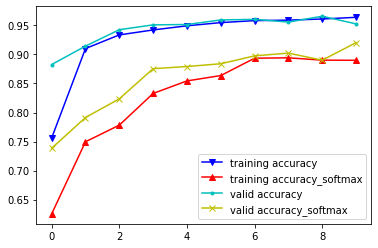

In [42]:
t = range(len(ta))
plot(t, ta, "bv-", t, ta_softmax, "r^-", t, va, "c.-", t, va_softmax, "yx-")
legend(["training accuracy", "training accuracy_softmax", "valid accuracy", "valid accuracy_softmax"])

可以發現原始 RNN 模型不管在 trainining accuracy 或是 valid accoracy 都高於 RNN + sigmoid 的模型，表示多加了 sigmoid 的轉換反而學習效率變差了！

但上方只有執行一次，說不定就僅僅剛好那次有這樣子的差異。為了確保真的多加了 sigmoid 轉換學習效率變差，我分別將這兩種模型分別模擬 10 次，其中每次都只做 5 次epochs，最後再來計算 loss 和 accuracy 分別的統計。


In [48]:
simulation(10, device, "RNN", train_data, test_data, 5, optimizer, criterion)

| Statistic         |   Train loss |   Train accuracy |   Valid loss |   Valid accuracy |
|-------------------+--------------+------------------+--------------+------------------|
| N                 |   10         |      10          |   10         |        10        |
| Epochs            |    5         |       5          |    5         |         5        |
| Min               |    0.165352  |       0.938266   |    0.147907  |         0.924164 |
| Mean              |    0.17935   |       0.949122   |    0.190299  |         0.946646 |
| Max               |    0.215899  |       0.952659   |    0.270021  |         0.960589 |
| Standard deviaion |    0.0135184 |       0.00386338 |    0.0388678 |         0.011211 |


In [49]:
simulation(10, device, "RNN_addSoftmax", train_data, test_data, 5, optimizer, criterion)

| Statistic         |   Train loss |   Train accuracy |   Valid loss |   Valid accuracy |
|-------------------+--------------+------------------+--------------+------------------|
| N                 |   10         |       10         |   10         |       10         |
| Epochs            |    5         |        5         |    5         |        5         |
| Min               |    1.55991   |        0.710888  |    1.54464   |        0.740844  |
| Mean              |    1.62826   |        0.834313  |    1.60555   |        0.857136  |
| Max               |    1.75165   |        0.902852  |    1.7223    |        0.91879   |
| Standard deviaion |    0.0520695 |        0.0521934 |    0.0517732 |        0.0517212 |


比較上方兩種結果可以發現，多加了 softmax 轉換，不管是在 training 和 valid dataset 上，學習效率都比沒有加的還要差！


### 1.3 學習不好的可能原因

這兩種差異在於後者多加了一層 softmax 的轉換，然而先前老師上課提到過，在分類問題上應該將 NN 的最後一層經過 softmax 使得變成每個預測值代表的是是每個類別的預測機率 (總合為 1)，再經由 cross entropy 的公式來計算 loss 的大小。然而在這邊卻「看似」加了 `nn.Softmax()` 以及用 `nn.CrossEntroypyLoss()` 表現反而比沒有加 `nn.Softmax()` 還要來的糟！

這主要的原由在於，PyTorch 在[CROSSENTROPYLOSS 官方文件](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)中就有提到：

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.

其 cross entroypy loss 的計算方式為：

$$
loss(x, class) = -log(\color{red}{\frac{exp(x[class])}{\sum_j exp(x[j])}})
$$

而 [`nn.Softmax()`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax) 的公式為：

$$
Softmax(x_i) = \frac{exp(x_i)}{\sum_j exp(x_j)}
$$

可以發現其實 `nn.CrossEntroypyLoss()` 就已經會做 softmax 的轉換了！若我們自己在模型中多加一次 softmax 轉換，這會使得對每一個預測類別的強度模糊掉。舉例來說：



In [49]:
softmax = nn.Softmax(dim=1)
p = t.tensor([[.5, .2, .1]])
print(p)
print(softmax(p))
print(softmax(softmax(p)))

tensor([[0.5000, 0.2000, 0.1000]])
tensor([[0.4147, 0.3072, 0.2780]])
tensor([[0.3610, 0.3242, 0.3148]])


因此，在這我們計算 loss 上會有所偏差。另一方面，我們知道在參數學習上如果我們多做一次 softmax，可能會使我們在做 backpropagation 所給予參數更新的權重又變小一些。總上所述，由於 cross entroypy loss 那邊就已經做過一次 softmax 轉換了，如果我們模型自己在最後一層多加 softmax 轉換，這會使得模型學習效率變差。  

## 2. RNN v.s. CNN (5 points)
Compare the results of 2.2.1 (RNN) & 2.3.1 (CNN) in 13_examples.ipynb.

The 1D-CNN seems to predict the time series better than the RNN. Why?

You may verify your hypotheses by computational experiments.

torch.Size([142, 1, 1]) (142,) 144


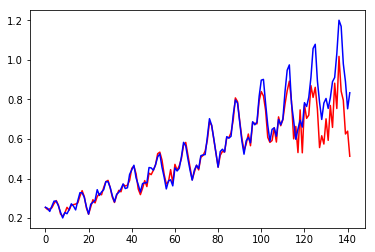

In [ ]:
# 2.2.1 (RNN):

torch.Size([142, 1]) (142,) 144


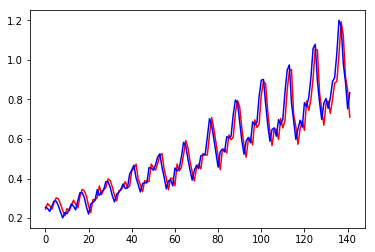

In [ ]:
# 2.3.1 (CNN):

老師上圖中有個小錯誤，藍線往左多平移了一格 (程式最後一行從 `plot(dataset[2:], ...` 修改為 `plot(dataset[1:], ...)`)

<img src='https://github.com/xup6y3ul6/Neural-and-Behavioral-Modeling/blob/main/13_Deep-learning%20Neural%20Networks%20(3-4)%20Recurrent%20Neural%20Network%20(RNN)/cnn1d_result.png?raw=true' alt="drawing" width="500"/>

因此實際上 CNN 在此範例中是預測的真的很好。


### 2.2 實驗假設

從 2.2.1 (RNN) 的那張圖大致上可以觀察到，其實在 training data 的 LSTM 其實是擬合的不錯，但是到了 testing data 就有很大的偏差，雖然說整個波形還是有出來，有描繪出短期的變化，但我覺得這個模型似乎沒抓到整個時間序列中，有一個長期上升的趨勢 (短視近利)。因此我猜想也許原本 LSTM 的設定中，僅以前兩期 (look_back = imput_size = 2) 納入考量可能太小了。因此我假設

> window = look_back = imput_size 的增加，可以讓 LSTM 模型預測未來資料能更好！



### 2.2 前置設定

In [50]:
# Please run your computational experiments and write your observations accordingly.
import pandas as pd

# Load data:
ts = pd.read_csv('https://raw.githubusercontent.com/xup6y3ul6/Neural-and-Behavioral-Modeling/main/13_Deep-learning%20Neural%20Networks%20(3-4)%20Recurrent%20Neural%20Network%20(RNN)/data.csv', usecols=[1]).dropna().values.astype('float32')

# Normalize:
max_value = np.max(ts)
min_value = np.min(ts)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, ts))

def get_data(window):
  # Prepare windowed data for our RNN model(s):
  dataX, dataY = [], []
  look_back = window
  for i in range(len(dataset) - look_back):
    a = dataset[i:(i + look_back)]
    dataX.append(a)
    dataY.append(dataset[i + look_back])
  data_X, data_Y = np.array(dataX), np.array(dataY)

  # Train-Test split:
  train_size = int(len(data_X) * 0.7) # 70% for training  
  test_size = len(data_X) - train_size
  train_X = data_X[:train_size]
  train_Y = data_Y[:train_size]
  test_X = data_X[train_size:]
  test_Y = data_Y[train_size:]

  # Reshape the data into (seq, batch, featue)
  train_X = train_X.reshape(-1, 1, window)
  train_Y = train_Y.reshape(-1, 1, 1)
  test_X = test_X.reshape(-1, 1, window)

  train_x = t.from_numpy(train_X)
  train_y = t.from_numpy(train_Y)
  test_x = t.from_numpy(test_X)
  
  return train_x, train_y, test_x, data_X, data_Y

In [51]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [69]:
def train_model(window, train_x, train_y):

  net_lstm = lstm_reg(input_size=window, hidden_size=10)
  criterion = nn.MSELoss()
  optimizer = t.optim.Adam(net_lstm.parameters(),lr=1e-2)

  # Training:
  iters = 1000+50*window
  for e in range(iters):
      # Forward:
      out = net_lstm(train_x)
      loss = criterion(out, train_y)
      # Backward:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #if (e + 1) % 100 == 0: # print loss every 100 epochs
      #    print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
  return net_lstm

def print_result(window, net_lstm, data_X, train_size):
  # Testing on the whole series (70% trained + 30% untrained):
  net_lstm2 = net_lstm.eval() 
  data_X2 = data_X.reshape(-1, 1, window)
  data_X3 = t.from_numpy(data_X2)
  pred_test1 = net_lstm2(data_X3) 
  pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
  
  # Visualization:
  plot(pred_test2, 'r', label='prediction')
  plot(dataset[window:], 'b', label='real')
  axvline(x=train_size, c='r', linestyle='--')
  title("LTRM: window is "+str(window))

### 2.3 結果

下方我分別調控不同的 window 值的大小，並作圖來看整個時間的真實值與 LSTM 預測表現上有無差距。

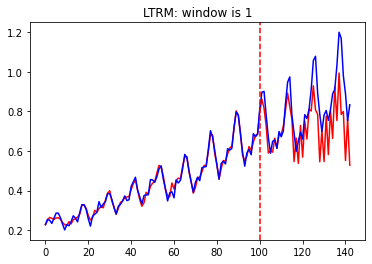

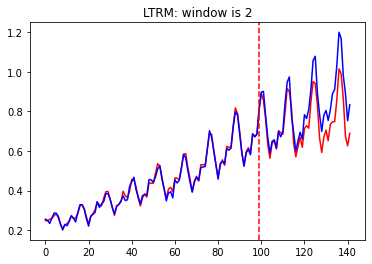

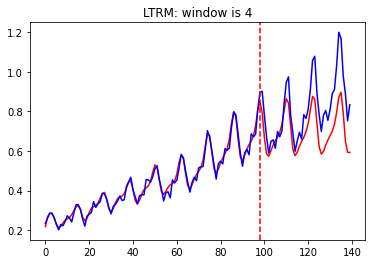

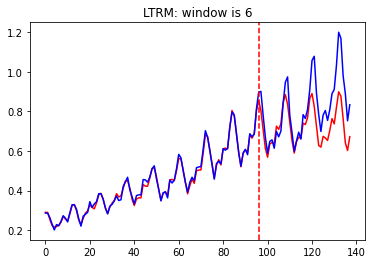

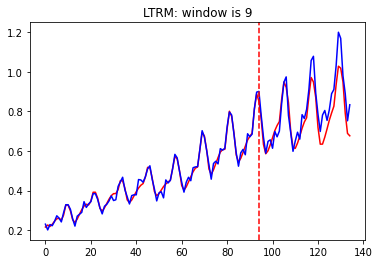

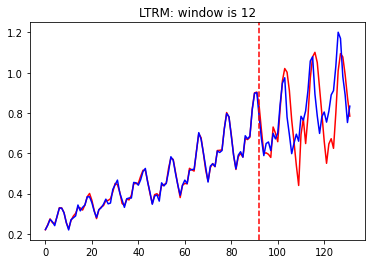

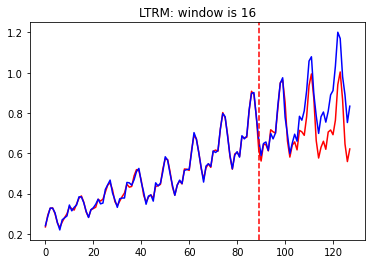

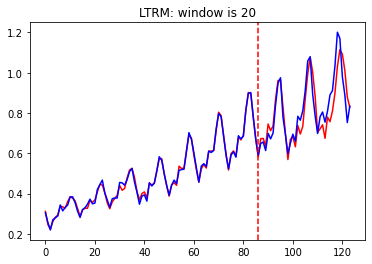

In [70]:
windows = np.array([1,2,4,6,9,12,16,20])
i = 1
for window in windows:
  train_x, train_y, test_x, data_X, data_Y = get_data(window)
  net_lstm = train_model(window, train_x, train_y)
  train_size = train_x.size(0)
  figure(i)
  print_result(window, net_lstm, data_X, train_size)
  i += 1

結果可以看到，當隨著 window 越大，LSTM 擬合的會越好，而且他在 testing data 上預測上也越加準確，比起 window 小的時候，更能捕捉到長期上升的趨勢。假若我們今想要找個「最佳」的 LSTM 模型，或許我們可以使用 cross-validation 的方式來尋找合適的 window 值。

但如果我們拿 LSTM (window=20) 來與範例 2.3.1 之 1D-CNN 的模型來比較，似乎 LSTM 還是的預測力還是差了一點，但原因就近為何目前還尚未有明確的想法QQ，但 LSTM 表險差的原因可能會是與 window 選擇不好有關 (太小值會短視近利)。